In [1]:
import matplotlib.pyplot as plt
from astropy import *
import astropy.units as u
from astropy.io import fits
import numpy as np
import glob as glob
import pandas as pd
from astropy.table import Table,vstack,hstack

import subprocess
import sys
import os
import logging
import numpy as np

from scipy.interpolate import interp1d
import time
from astropy.stats import sigma_clip
import scipy
from scipy.interpolate import interp1d
from scipy import interpolate

In [2]:
path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
galah = Table.read(path + 'galah_dr4_allstar.fits')

# Get Hunt Members

In [3]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
hunt_catalog_list = Vizier.find_catalogs('J/A+A/686/A42')
hunt_catalogs = Vizier.get_catalogs(hunt_catalog_list.keys())
hunt_members = hunt_catalogs[1]

# Get Cavallo Parameters

In [4]:
catalog_list = Vizier.find_catalogs('J/AJ/167/12')
catalogs = Vizier.get_catalogs(catalog_list.keys())
cantello_parameters = catalogs[0]

In [5]:
cantello_parameters = cantello_parameters[cantello_parameters['Quality'] < 1]
cantello_parameters = cantello_parameters[cantello_parameters['kind']=='o']
cantello_parameters
# truth = np.isin(good_cantello_parameters['Cluster'],np.unique(hunt_members['Name']))
# good_cantello_parameters = good_cantello_parameters[truth]

# truth = np.isin(hunt_members['Name'],good_cantello_parameters['Cluster'])
# hunt_members = hunt_members[truth]

Cluster,RA_ICRS,DE_ICRS,kind,plx,e_plx,CMDclass,Quality,logAge16,logAge50,logAge84,[Fe/H]16,[Fe/H]50,[Fe/H]84,AV16,AV50,AV84,dMod16,dMod50,dMod84,X,Y,Z,Rgc
,deg,deg,,mas,mas,,,log(yr),log(yr),log(yr),,,,mag,mag,mag,mag,mag,mag,kpc,kpc,kpc,kpc
str20,float64,float64,str1,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32
1636-283,249.85718173264,-28.39146506616,o,0.125,0.034,0.04,0,9.47,9.56,9.66,-0.72,-0.54,-0.34,1.67,1.80,1.93,14.02,14.30,14.57,7.0169197997616681,-0.99596592884526,1.5422692480782,1.488
ADS_16795,348.65321156602,57.26469379429,o,4.778,0.083,0.83,0,7.43,7.54,7.64,-0.18,-0.07,0.04,0.67,0.77,0.86,6.50,6.67,6.82,-0.0740483673230283,0.20231945404972,0.029838109742435,8.199
AH03_J0748+26.9,117.16371118237,-26.96443007594,o,0.211,0.021,1.00,0,7.90,8.00,8.13,-0.72,-0.55,-0.39,1.43,1.50,1.57,12.53,12.77,12.99,-1.6147402814801095,-3.1960360488146,0.007144081729555,10.248
ASCC_100,284.62971873485,32.43666773222,o,2.749,0.030,0.94,0,7.01,7.21,7.39,-0.06,0.06,0.23,0.32,0.46,0.59,7.64,7.86,8.11,0.1652355662386764,0.32444428236325,0.12380460208814,7.963
ASCC_101,288.41450533645,36.28386326207,o,2.506,0.035,0.99,0,8.06,8.14,8.24,0.30,0.39,0.46,0.34,0.40,0.46,7.92,8.04,8.18,0.1493487488830771,0.36823665080706,0.12248168701391,7.981
ASCC_105,295.49878975919,27.29586866253,o,1.775,0.025,1.00,0,7.58,7.65,7.72,-0.06,0.04,0.12,0.67,0.72,0.78,8.71,8.83,8.96,0.2671246511988450,0.518317156154,0.061951031436812,7.872
ASCC_106,295.58161632159,1.42091099476,o,1.324,0.027,1.00,0,8.06,8.16,8.28,0.36,0.50,0.67,1.09,1.19,1.27,9.19,9.40,9.58,0.5700315456556089,0.48011266516015,-0.099913839037164,7.567
ASCC_107,297.13515559847,21.97556362072,o,1.125,0.025,1.00,0,7.24,7.32,7.42,0.09,0.22,0.38,1.48,1.56,1.64,9.74,9.92,10.10,0.4978186005151253,0.82467138773347,0.0086356710225351,7.669


In [82]:
truth = np.isin(hunt_members['GaiaDR3'],galah['gaiadr3_source_id'])
galah_hunt_members = hunt_members[truth]

truth = np.isin(galah['gaiadr3_source_id'],galah_hunt_members['GaiaDR3'])
galah_cluster_candidates = galah[truth]

In [83]:
galah_hunt_members.sort('Prob',reverse=True)
unique_ids,indices,counts = np.unique(galah_hunt_members['GaiaDR3'],return_index=True,return_counts=True)
galah_hunt_members = galah_hunt_members[indices]

galah_cluster_candidates.sort('gaiadr3_source_id')
galah_hunt_members.sort('GaiaDR3')

print(len(galah_cluster_candidates), len(galah_hunt_members))

galah_cluster_candidates['cluster'] = galah_hunt_members['Name']
galah_cluster_candidates['prob'] = galah_hunt_members['Prob']

galah_cluster_candidates['pmra'] = galah_hunt_members['pmRA']
galah_cluster_candidates['pmde'] = galah_hunt_members['pmDE']
galah_cluster_candidates['plx'] = galah_hunt_members['Plx']

galah_cluster_candidates['Gmag'] = galah_hunt_members['Gmag']
galah_cluster_candidates['BPmag'] = galah_hunt_members['BPmag']
galah_cluster_candidates['RPmag'] = galah_hunt_members['RPmag']

8714 8714


In [84]:
truth = np.isin(galah_cluster_candidates['cluster'],cantello_parameters['Cluster'])
galah_cluster_candidates = galah_cluster_candidates[truth]

In [85]:
from isochrones.mist import MISTIsochroneGrid
from isochrones import get_ichrone
from isochrones import get_ichrone, SingleStarModel, BinaryStarModel

from isochrones.priors import *

def get_distance(dmnn, av):
    return 10.0**(0.2*(dmnn + 5 - av))

cantello_parameters['dist16'] = get_distance(cantello_parameters['dMod16'], cantello_parameters['AV16'])
cantello_parameters['dist50'] = get_distance(cantello_parameters['dMod50'], cantello_parameters['AV50'])
cantello_parameters['dist84'] = get_distance(cantello_parameters['dMod84'], cantello_parameters['AV84'])

In [86]:
def get_isochrone(cparams):
    # cparams = good_cantello_parameters[good_cantello_parameters['Cluster']==i['cluster']]
    N = 3000
    masses = FlatPrior((0.1,5)).sample(N)
    feh = cparams['[Fe/H]50']
    age = cparams['logAge50']  # 6 Gyr
    distance = cparams['dist50']  # 8 kpc
    AV = cparams['AV50']

    tracks = get_ichrone('mist', tracks=True)
    df = tracks.generate(masses, age, feh, distance=distance, AV=AV)
    # df = df[df['G_mag'] > 6]
    # df = df[df['G_mag'] > 13]
    # df = df[df['logg'] > 3.5]
    df = df.sort_values(by=['G_mag'])
    # df = df[df['Teff'] < 8000]
    df['BP_RP'] = df['BP_mag'] - df['RP_mag']
    return df

from scipy.interpolate import CubicSpline
def get_interploted_eep(df,df_param1,df_param2,star,star_param1):
    cs = CubicSpline(df[df_param1], df[df_param2])
    return cs(star[star_param1])

def get_interploted_parameters(df,param,eep):
    cs = CubicSpline(df['eep'], df[param])
    return cs(eep)

In [87]:
galah_clusters = np.unique(galah_cluster_candidates['cluster'])

In [88]:
temp = []
for i in galah_clusters:
    cluster = galah_cluster_candidates[galah_cluster_candidates['cluster']==i]
    science_cluster = cluster[(cluster['prob'] > 0.5)]
    cparams = cantello_parameters[cantello_parameters['Cluster']==i]
    # science_cluster = science_cluster[science_cluster['snr_px_ccd1'] > 30]
    # science_cluster = science_cluster[science_cluster['snr_px_ccd2'] > 30]
    science_cluster = science_cluster[science_cluster['snr_px_ccd3'] > 75]
    # science_cluster = science_cluster[science_cluster['snr_px_ccd4'] > 30]

    mdwarfs = science_cluster[(science_cluster['teff'] < 4100) & (science_cluster['logg'] > 3.2)]
    baseline = science_cluster[(science_cluster['teff'] > 4100) & (science_cluster['teff'] < 6000) & (science_cluster['logg'] > 3.2)]

    if len(mdwarfs) > 0 and len(baseline) > 0:
        temp.append(cluster)

galah_cluster_members = vstack(temp)
galah_cluster_members

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str20,float64,float64,float64,float64,float64,float64,float64
190211002201010,05282834+0011020,3221041475601931776,orion,-8,allstar,58525.535,82.11812591552734,0.18391944468021393,0,0,2,1024,67.87181,97.85143,123.70043,116.98479,1.0595328,94,5000_4.00_0.00,5000_4.00_0.00,212.77112,True,27.27044,0.232247,--,--,--,--,-24.36518669128418,5015.0728,68.003265,4.1868215,0.110626556,-0.03358274,0.056607284,0,1.5602596,0.2820696,12.793293,1.426767,1.9688536,0.035288833,0,-0.14005493,0.08742853,32,-0.8150409,0.121719636,33,-0.19366671,0.064413145,0,0.004526317,0.016681232,0,-0.011909723,0.016845873,0,0.11024055,0.02898262,0,-0.011295437,0.017010799,0,0.43258804,0.024673657,0,0.18757272,0.017495545,0,-0.111411

In [89]:
def parameter_pruning(cluster, param, n=2):
    low = np.nanmedian(np.array(cluster[param])) - n*np.nanstd(np.array(cluster[param]))
    high = np.nanmedian(np.array(cluster[param])) + n*np.nanstd(np.array(cluster[param]))

    truth = (cluster[param] <= high) & (cluster[param] >= low)
    return truth

def plx_pruning(cluster, cluster_params):
    joint_plx_err = np.sqrt(np.array(cluster['parallax_error'])**2 + cluster_params['e_plx']**2)

    upper = cluster_params['plx'] + 3*joint_plx_err
    lower = cluster_params['plx'] - 3*joint_plx_err

    truth = (np.array(cluster['parallax']) < upper) & (np.array(cluster['parallax']) > lower)
    return truth
    
def get_best_eep(star, df):

    # truth = abs(df['Teff'] - star['teff']) < 1000
    # df = df[truth]
    # df = df.reset_index(drop=True)
    # if len(df['eep']) == 0:
    #     return 0, np.nan, np.nan

    df['bp_rp'] = df['BP_mag'] - df['RP_mag']
    bp_rp_chi2 = abs(star['bp_rp'] - df['bp_rp']) / (0.02 * 2**0.5)
    g_chi2 = abs(star['phot_g_mean_mag'] - df['G_mag']) / 0.02
    j_chi2 = abs(star['j_m'] - df['J_mag']) / 0.02
    k_chi2 = abs(star['ks_m'] - df['K_mag']) / 0.02
    h_chi2 = abs(star['h_m'] - df['H_mag']) / 0.02
    
    if np.isfinite(star['W2mag']):
        w2_chi2 = abs(star['phot_g_mean_mag'] - df['W2_mag']) / 0.02
        dist = (bp_rp_chi2**2 + g_chi2**2 + j_chi2**2 + k_chi2**2 + h_chi2**2 + w2_chi2**2)
        phot_dist = (dist**0.5 / 6)
    else:
        dist = (bp_rp_chi2**2 + g_chi2**2 + j_chi2**2 + k_chi2**2 + h_chi2**2)
        phot_dist = (dist**0.5 / 5)

    idx = np.argmin(dist)
    return 1, df.loc[idx], phot_dist[idx]

def prune_iso(cluster):
    upper = np.nanmedian(cluster['phot_distance']) + 3*np.nanstd(cluster['phot_distance'])
    # print(upper)
    truth = cluster['phot_distance'] < upper
    return truth

In [90]:
galah_cluster_members['closest_eep'] = -9999.99
galah_cluster_members['phot_distance'] = -9999.99

temp = []
for i in np.unique(galah_cluster_members['cluster']):
    cluster = galah_cluster_members[galah_cluster_members['cluster']==i]
    cparams = cantello_parameters[cantello_parameters['Cluster']==i]
    df = get_isochrone(cparams)

    for j in cluster:
        quality, eep, dist = get_best_eep(j, df)
        if quality == 1:
            j['phot_distance'] = dist
            j['closest_eep'] = eep['eep']
    temp.append(cluster)
    # print(np.array(cluster['closest_eep']))

galah_cluster_members = vstack(temp)
galah_cluster_members

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag,closest_eep,phot_distance
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64
190211002201010,05282834+0011020,3221041475601931776,orion,-8,allstar,58525.535,82.11812591552734,0.18391944468021393,0,0,2,1024,67.87181,97.85143,123.70043,116.98479,1.0595328,94,5000_4.00_0.00,5000_4.00_0.00,212.77112,True,27.27044,0.232247,--,--,--,--,-24.36518669128418,5015.0728,68.003265,4.1868215,0.110626556,-0.03358274,0.056607284,0,1.5602596,0.2820696,12.793293,1.426767,1.9688536,0.035288833,0,-0.14005493,0.08742853,32,-0.8150409,0.121719636,33,-0.19366671,0.064413145,0,0.004526317,0.016681232,0,-0.011909723,0.016845873,0,0.11024055,0.02898262,0,-0.011295437,0.017010799,0,0.43258804,0.02

In [91]:
temp = []
for i in galah_clusters:
    cluster = galah_cluster_members[galah_cluster_members['cluster']==i]
    cluster = cluster[(cluster['prob'] > 0.5)]
    cparams = cantello_parameters[cantello_parameters['Cluster']==i]
    iso_truth = prune_iso(cluster)
    cluster = cluster[iso_truth]

    key = False
    count = 0
    if len(cluster) > 1:
        while(key==False):
            pmra_truth = parameter_pruning(cluster, 'pmra',n=3)
            pmde_truth = parameter_pruning(cluster, 'pmde',n=3)
            rv_truth = parameter_pruning(cluster,'rv_comp_1')
            plx_truth = plx_pruning(cluster,cparams)
            
            truth = (pmra_truth & pmde_truth & plx_truth & rv_truth)
            cluster = cluster[truth]
            count +=1

            if np.nanstd(np.array(cluster['rv_comp_1'])) < 3 or count == 10:
                key = True

        cluster = cluster[cluster['snr_px_ccd3'] > 100]
        if np.nanstd(np.array(cluster['rv_comp_1'])) < 3 and len(cluster) > 1:
            temp.append(cluster)
    # print()

clean_galah_cluster_members = vstack(temp)
clean_galah_cluster_members

# plt.scatter(x['teff'],x['logg'])

/uufs/astro.utah.edu/common/home/u1363702/software/pkg/miniforge3/envs/isochrones/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/uufs/astro.utah.edu/common/home/u1363702/software/pkg/miniforge3/envs/isochrones/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag,closest_eep,phot_distance
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64
190211002201010,05282834+0011020,3221041475601931776,orion,-8,allstar,58525.535,82.11812591552734,0.18391944468021393,0,0,2,1024,67.87181,97.85143,123.70043,116.98479,1.0595328,94,5000_4.00_0.00,5000_4.00_0.00,212.77112,True,27.27044,0.232247,--,--,--,--,-24.36518669128418,5015.0728,68.003265,4.1868215,0.110626556,-0.03358274,0.056607284,0,1.5602596,0.2820696,12.793293,1.426767,1.9688536,0.035288833,0,-0.14005493,0.08742853,32,-0.8150409,0.121719636,33,-0.19366671,0.064413145,0,0.004526317,0.016681232,0,-0.011909723,0.016845873,0,0.11024055,0.02898262,0,-0.011295437,0.017010799,0,0.43258804,0.02

In [92]:
n_fgk = 0
n_mdwarfs = 0
temp = []
for i in np.unique(clean_galah_cluster_members['cluster']):
    cluster = clean_galah_cluster_members[clean_galah_cluster_members['cluster']==i]

    truth = (cluster['teff'] > 4100) & (cluster['teff'] < 5500) & (cluster['logg'] > 3.2)
    baselines = cluster[truth]

    truth = (cluster['teff'] < 4100) & (cluster['logg'] > 3.2)
    mdwarfs = cluster[truth] 

    final_members = vstack([baselines,mdwarfs])

    # print(len(baselines), len(mdwarfs))

    if len(mdwarfs) > 0 and len(baselines) > 0:
        print(i, np.nanstd(cluster['rv_comp_1']), len(baselines), len(mdwarfs))
        temp.append(final_members)
        n_mdwarfs += len(mdwarfs) 
        n_fgk += len(baselines) 

candidate_cluster_members = vstack(temp)
candidate_clusters = np.unique(candidate_cluster_members['cluster'])
print('N M-dwarfs: {}'.format(n_mdwarfs))
print('N FGK: {}'.format(n_fgk))
print('N Clusters: {}'.format(len(candidate_clusters)))

Collinder_69 1.538356 8 2
HSC_2907 0.69425094 2 1
Melotte_22 1.5164366 7 1
Melotte_25 2.1698308 4 2
OCSN_96 2.8117852 4 3
UPK_640 0.28723028 2 1
N M-dwarfs: 10
N FGK: 27
N Clusters: 6


In [93]:
plt.style.use(path +'paper_style.mplstyle')
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams['text.usetex'] = True

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag,closest_eep,phot_distance
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64
190224002101222,05390587+0919451,3336346882048786688,orion,-8,allstar,58538.46,84.77445983886719,9.329177856445312,104,0,2,0,61.552456,93.775856,144.22565,119.145294,1.29494,94,5250_4.00_-0.50,5500_4.00_-0.50,141.19888,True,25.700726,0.26400205,62.700726,35.997753,28.84387,5.2104487,-27.557971954345703,5429.0195,70.496216,4.09949,0.11045269,-0.32114398,0.06555266,0,0.28389537,0.2879469,26.215242,1.4263496,1.551656,0.061259974,0,0.26144984,0.042580545,32,-0.46687865,0.22128189,33,0.4903856,0.07820589,0,-0.3872671,0.03615579,0,0.47889397,0.016934156,0,-0.10446543,0.050867483,0,0.073745996,0.028181

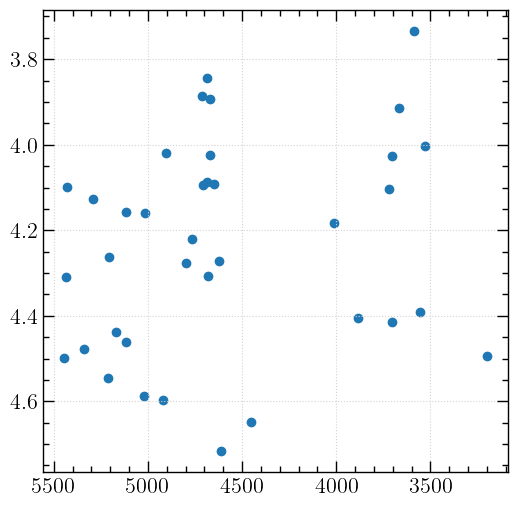

In [96]:
plt.figure(figsize=(6,6))
plt.scatter(candidate_cluster_members['teff'],candidate_cluster_members['logg'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

candidate_cluster_members

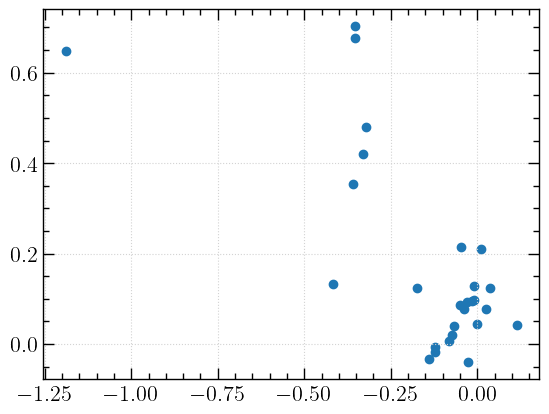

In [97]:
# plt.hist(candidate_cluster_members['fe_h'])
fgks = candidate_cluster_members[candidate_cluster_members['teff'] > 4100]
plt.scatter(fgks['fe_h'],fgks['mg_fe'])

In [98]:
candidate_cluster_members.write('galah_candidate_cluster_members.fits',overwrite=True)

In [99]:
sobject_ids = list(candidate_cluster_members['sobject_id'])
np.savetxt('galah_cluster_member_ids.txt',sobject_ids,fmt='%f')

In [100]:
string = ''
for i in sobject_ids:
    string = string + str(i) + ','
string

'190224002101222,190205001601103,190205001601126,190205001601071,190205001601042,190205001601165,190205001601018,190205001601399,190205001601083,190205001601068,140809001601238,140713001901399,140608003701322,150109001001045,150109001001186,160106001601095,150109001001355,150109001001254,160106001601027,150109001001278,150109001001175,181225002101151,170829002901175,170829002901201,151008004001047,170117002101072,170130001601354,150413005601075,150429003601252,140610004401001,140609002101390,140608003101141,140608003101024,210421006401233,220706001901266,220706001901188,210421008001176,'

(array([2., 2., 9., 8., 8., 5., 0., 0., 1., 2.]),
 array([ 19.0799942 ,  36.42506409,  53.77013779,  71.11521149,
         88.46028137, 105.80535126, 123.15042877, 140.49549866,
        157.84057617, 175.18563843, 192.53070068]),
 <BarContainer object of 10 artists>)

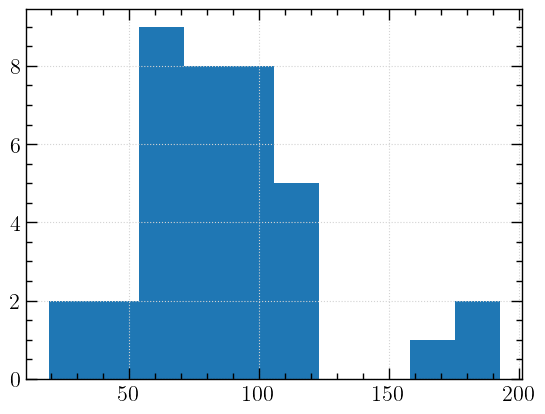

In [103]:
# final_cluster_parameters = cantello_parameters[np.isin(cantello_parameters['Cluster'], candidate_clusters)]
# final_cluster_parameters.write('galah_candidate_cluster_parameters.fits',overwrite=True)

plt.hist(candidate_cluster_members['snr_px_ccd2'])

(array([5., 2., 0., 0., 1., 1., 0., 0., 0., 1.]),
 array([103.40538788, 123.38078308, 143.35617065, 163.33157349,
        183.30696106, 203.28234863, 223.25775146, 243.2331543 ,
        263.20852661, 283.18392944, 303.15933228]),
 <BarContainer object of 10 artists>)

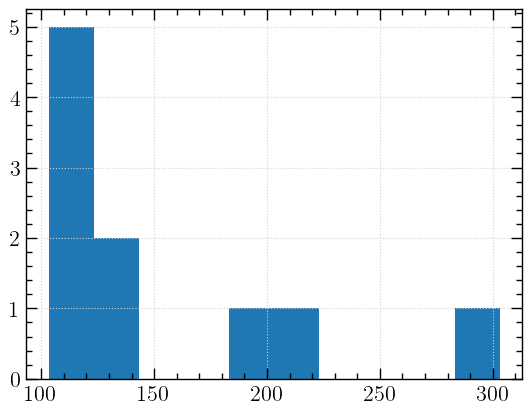

In [110]:
# final_cluster_parameter
galah_mdwarfs = candidate_cluster_members[(candidate_cluster_members['teff'] < 4100) & (candidate_cluster_members['logg'] > 3.2)]
# galah_mdwarfs = galah_mdwarfs[galah_mdwarfs['snr_px_ccd3'] > 30]
plt.hist(galah_mdwarfs['snr_px_ccd3'])